In [1]:
import tensorflow
from tensorflow.keras.layers import Activation, Dense, Dropout, Conv2D, \
                         Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
import librosa
import librosa.display
import numpy as np
import pandas as pd
import random
import os

import warnings
warnings.filterwarnings('ignore')


In [4]:
# Read Data
audio_dataset_path = r"C:\Users\globb\Desktop\Final dataset\audio\\"
metadata = pd.read_csv(r'C:\Users\globb\Desktop\Final dataset\metadata.csv')
metadata.head(5)

,filename,category,classid
0,audioset_-5dCv5_nvU8_205_210.wav,cough,1
1,audioset_-ej81N6Aqo4_5_10.wav,cough,1
2,audioset_-fURq3jhY1Y_0_5.wav,cough,1
3,audioset_-hu5q-Nn4BM_70_75.wav,cough,1
4,audioset_-i8bUT9k9FU_35_40.wav,cough,1


In [5]:
#get ps.shape for different durations
#y, sr = librosa.load(r"C:\Users\globb\Desktop\Final dataset\audio\audioset_CsNTOw4LTBw_100_105.wav", duration=4)
y, sr = librosa.load(r"C:\Users\globb\Desktop\Final dataset\audio\audioset_4lOXjW8rpxU_0_5.wav", duration=4)
ps = librosa.feature.melspectrogram(y=y, sr=sr)
ps.shape

(128, 173)

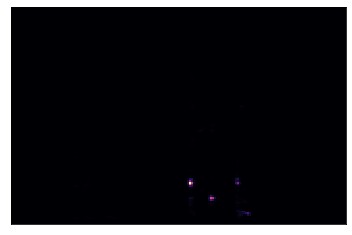

In [12]:
librosa.display.specshow(ps)

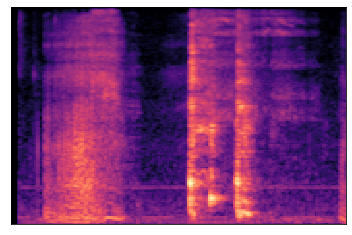

In [14]:
S_DB = librosa.power_to_db(ps, ref=np.max)
#librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='mel');
librosa.display.specshow(S_DB);

In [7]:
from tqdm import tqdm
extracted_features=[]
for index_num,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),str(row["filename"]))
    final_class_labels = row["classid"]
    y, sr = librosa.load(file_name, duration=4) 
    ps = librosa.feature.melspectrogram(y=y, sr=sr)
    ps = librosa.power_to_db(ps, ref=np.max) # Converts melspectogram into dB instead of Amplitude squared
    if ps.shape != (128, 173): continue
    extracted_features.append([ps,final_class_labels])

1302it [03:03,  7.08it/s]


In [8]:
# Read Augmented Data
augmented_dataset_path = r"E:\Final dataset\augmented_data\\"
metadata = pd.read_csv(r'E:\Final dataset\metadata_augmented.csv')
metadata.head(5)

,filename,category,classid
0,audioset_-5dCv5_nvU8_205_210.wavcough_gain.wav,cough,1
1,audioset_-5dCv5_nvU8_205_210.wavcough_noise.wav,cough,1
2,audioset_-5dCv5_nvU8_205_210.wavcough_pitch.wav,cough,1
3,audioset_-5dCv5_nvU8_205_210.wavcough_polarity...,cough,1
4,audioset_-ej81N6Aqo4_5_10.wavcough_gain.wav,cough,1


In [9]:
#Get melspectogram for augmented dataset
for index_num,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(augmented_dataset_path),str(row["filename"]))
    final_class_labels = row["classid"]
    y, sr = librosa.load(file_name, duration=4) 
    ps = librosa.feature.melspectrogram(y=y, sr=sr)
    ps = librosa.power_to_db(ps, ref=np.max) # Converts melspectogram into dB instead of Amplitude squared
    if ps.shape != (128, 173): continue
    extracted_features.append([ps,final_class_labels])

5208it [01:49, 47.51it/s]


In [10]:
print("Number of samples: ", len(extracted_features))

Number of samples:  6510


In [11]:
dataset = extracted_features
random.shuffle(dataset)

train = dataset[:6000]
test = dataset[6000:]

X_train, y_train = zip(*train)
X_test, y_test = zip(*test)

In [12]:
# Reshape for CNN input
X_train = np.array([x.reshape( (128, 173, 1) ) for x in X_train])
X_test = np.array([x.reshape( (128, 173, 1) ) for x in X_test])

In [13]:
# One-Hot encoding for classes
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y_train = tensorflow.keras.utils.to_categorical(labelencoder.fit_transform(y_train))
y_test = np.array(tensorflow.keras.utils.to_categorical(labelencoder.fit_transform(y_test)))

In [14]:
X_train.shape

(6000, 128, 173, 1)

In [15]:
y_train.shape

(6000, 3)

In [16]:
import matplotlib.pyplot as plt

In [17]:
def plot_history(history):
    
    fig, axs = plt.subplots(2,constrained_layout=True)

    #create accuracy subplot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].set_xlabel("Epoch")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    #create error subplot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

In [18]:
print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [19]:
model = Sequential()
input_shape=(128, 173, 1)

model.add(Conv2D(24, (5, 5), strides=(1, 1), input_shape=input_shape, kernel_regularizer=regularizers.L2(0.001)))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid", kernel_regularizer=regularizers.L2(0.001)))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid", kernel_regularizer=regularizers.L2(0.001)))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(rate=0.5))

model.add(Dense(64, kernel_regularizer=regularizers.L2(0.008)))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(3))
model.add(Activation('softmax'))

INFO:tensorflow:Assets written to: saved_models/audio_classifier_portable\assets
Epoch 1/250
94/94 [==============================] - 10s 36ms/step - loss: 3.5448 - accuracy: 0.4155 - val_loss: 1.9258 - val_accuracy: 0.4216

Epoch 00001: val_loss improved from inf to 1.92577, saving model to saved_models\audio_classification.hdf5
Epoch 2/250
94/94 [==============================] - 3s 29ms/step - loss: 1.9157 - accuracy: 0.4452 - val_loss: 1.7796 - val_accuracy: 0.4725

Epoch 00002: val_loss improved from 1.92577 to 1.77959, saving model to saved_models\audio_classification.hdf5
Epoch 3/250
94/94 [==============================] - 3s 29ms/step - loss: 1.7949 - accuracy: 0.4790 - val_loss: 1.6825 - val_accuracy: 0.5510

Epoch 00003: val_loss improved from 1.77959 to 1.68252, saving model to saved_models\audio_classification.hdf5
Epoch 4/250
94/94 [==============================] - 3s 29ms/step - loss: 1.6977 - accuracy: 0.5012 - val_loss: 1.5843 - val_accuracy: 0.5804

Epoch 00004: val_

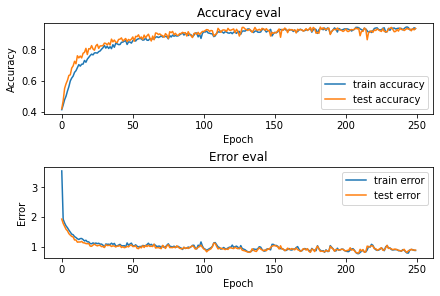

16/16 [==============================] - 0s 17ms/step - loss: 0.8823 - accuracy: 0.9333
Test loss: 0.8822706937789917
Test accuracy: 0.9333333373069763
Training completed in time:  0:11:34.078414


In [20]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')
model.save('saved_models/audio_classifier_portable')

## Trianing my model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 250
num_batch_size = 64

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

history = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)
plot_history(history)

score = model.evaluate(
	X_test,
	y_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

duration = datetime.now() - start
print("Training completed in time: ", duration)


In [24]:
filename="sneeze2.wav"

y, sr = librosa.load(filename, duration=4) 
ps = librosa.feature.melspectrogram(y=y, sr=sr)

ps=ps.reshape(1,ps.shape[0],ps.shape[1],1)
#ps.shape

#predicted_label=model.predict_classes(ps) #deprecated
predicted_label=np.argmax(model.predict(ps),axis=-1)
#print(predicted_label)

prediction_class = labelencoder.inverse_transform(predicted_label) 
prediction_class



array([2])